In [1]:
import sys
sys.path.append("./functions")

from utils import *
from model_bet import *
import pandas as pd
import os
import time

### Generating no trained models

In [2]:
if not os.path.exists('./models/notrained'):
   os.makedirs('./models/notrained')

for seed in range(50):

    for model_size in [10000,100000,300000,900000]:

        torch.manual_seed(seed)
        
        saving_path = f"./models/notrained/notrained_{model_size}_size_{seed}_seed"

        #Model parameters
        hidden = 20
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = GNN_Bet(ninput=model_size,nhid=hidden,dropout=0.6)
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)

        torch.save(model.state_dict(), saving_path)

### trained vs  not trained models

In [4]:

torch.manual_seed(15)

test_files = {
    10000: '1-wiki-Vote_1_test_10000_size_10_splitseed.pickle',
    100000: '2-soc-Epinions_1_test_100000_size_10_splitseed.pickle',
    300000: '3-email-EuAll_1_test_300000_size_10_splitseed.pickle',
    900000: '4-web-Google_1_test_900000_size_10_splitseed.pickle'}

genseed = 10
numtrain = 5
splitseed = 0
copies = 10
nodes = 100

R = {}

for size in test_files:

    test_graph = test_files[size]
    train_graph = f'SF_5_graphs_{nodes}_nodes_{genseed}_genseed_{numtrain}_train_{copies}_copies_{size}_size_{splitseed}_splitseed.pickle'
    R[test_graph] = {"train_graph":train_graph,"size":size}
    R[test_graph]['r'] = {'true': [],'pred': []}

    #Load test data
    with open("./data_splits/test/"+test_graph,"rb") as fopen:
        list_graph_test,list_n_seq_test,list_num_node_test,bc_mat_test,deg_mat_test = pickle.load(fopen)

    # Load training data
    with open("./data_splits/train/"+train_graph,"rb") as fopen:
        list_graph_train,list_n_seq_train,list_num_node_train,bc_mat_train,deg_mat_train = pickle.load(fopen)


    #Get adjacency matrices from graphs
    list_adj_train,list_adj_t_train = graph_to_adj_bet(list_graph_train,list_n_seq_train,list_num_node_train,size)
    list_adj_test,list_adj_t_test = graph_to_adj_bet(list_graph_test,list_n_seq_test,list_num_node_test,size)

    for seed in range(50):

        currentresult = {'seed':seed}

        print(f"\nTest: {test_graph}, Size: {size}, Seed: {seed}, Time: {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}")
        model_path = f"./models/notrained/notrained_{size}_size_{seed}_seed"

        #Model parameters
        hidden = 20
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = GNN_Bet(ninput=size,nhid=hidden,dropout=0.6)
        model.load_state_dict(torch.load(model_path))
        model.to(device)
        optimizer = torch.optim.Adam(model.parameters(),lr=0.0005)

        with torch.no_grad():
            r = test_onegraph(list_adj_test,list_adj_t_test,list_num_node_test,bc_mat_test,deg_mat_test,model=model,device=device,size=size)

        currentresult['no_train'] = {'pred':r['pred'],'kt':r["kt"]}
        print(f'no trained: {r["kt"]}')

        if len(R[test_graph]['r']['true']) == 0:
            R[test_graph]['r']['true'] = r['true']

        train(list_adj_train,list_adj_t_train,list_num_node_train,bc_mat_train,model=model,device=device,optimizer=optimizer,size=size)

        with torch.no_grad():
            r = test_onegraph(list_adj_test,list_adj_t_test,list_num_node_test,bc_mat_test,deg_mat_test,model=model,device=device,size=size)
        
        print(f'trained: {r["kt"]}')

        currentresult['train'] = {'pred':r['pred'],'kt':r["kt"]}

        R[test_graph]['r']['pred'].append(currentresult)

        with open("./outputs/output_train_no_train.pickle","wb") as fopen:
            pickle.dump(R,fopen)

Processing 50 graphs...
Processing 1 graphs...

Test: 1-wiki-Vote_1_test_10000_size_10_splitseed.pickle, Size: 10000, Seed: 0, Time: 10/05/2023 19:56:56
no trained: -0.3289983799021379
trained: 0.925418967932067

Test: 1-wiki-Vote_1_test_10000_size_10_splitseed.pickle, Size: 10000, Seed: 1, Time: 10/05/2023 19:57:03
no trained: -0.14254996826113997
trained: 0.9264838599662897

Test: 1-wiki-Vote_1_test_10000_size_10_splitseed.pickle, Size: 10000, Seed: 2, Time: 10/05/2023 19:57:10
no trained: 0.9068306358378594
trained: 0.9175503332272875

Test: 1-wiki-Vote_1_test_10000_size_10_splitseed.pickle, Size: 10000, Seed: 3, Time: 10/05/2023 19:57:18
no trained: 0.39922764371355685
trained: 0.9192346299568921

Test: 1-wiki-Vote_1_test_10000_size_10_splitseed.pickle, Size: 10000, Seed: 4, Time: 10/05/2023 19:57:26
no trained: -0.43991726965228994
trained: 0.9180561850855105

Test: 1-wiki-Vote_1_test_10000_size_10_splitseed.pickle, Size: 10000, Seed: 5, Time: 10/05/2023 19:57:34
no trained: -0.40

FileNotFoundError: [Errno 2] No such file or directory: './data_splits/train/SF_5_graphs_100_nodes_10_genseed_5_train_10_copies_100000_size_0_splitseed.pickle'

In [5]:
import pickle
import matplotlib.pyplot as plt

path = './outputs/output_train_no_train.pickle'


with open(path,'rb') as f:
    data = pickle.load(f)

50


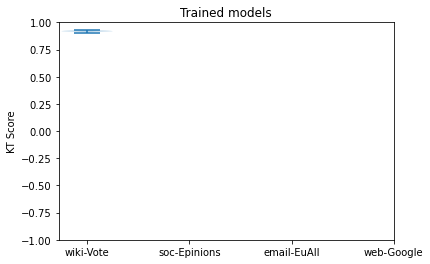

In [6]:
# Trained results 

ys = []
for net in data:
    v = [k['train']['kt'] for k in data[net]['r']['pred']]
    ys.append(v)
print(len(ys[0]))
plt.violinplot(ys)
plt.title("Trained models")
plt.xticks([1,2,3,4],['wiki-Vote', 'soc-Epinions' , 'email-EuAll','web-Google'])
plt.ylim([-1,1])
plt.ylabel("KT Score")
plt.show()

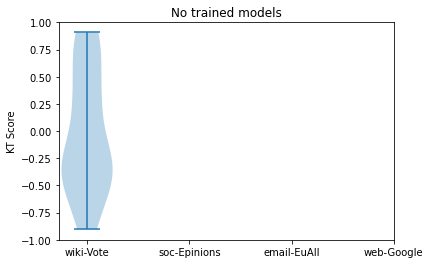

In [7]:
# NO Trained results 

ys = []
for net in data:
    v = [k['no_train']['kt'] for k in data[net]['r']['pred']]
    ys.append(v)

plt.violinplot(ys)
plt.title("No trained models")
plt.xticks([1,2,3,4],['wiki-Vote', 'soc-Epinions' , 'email-EuAll','web-Google'])
plt.ylim([-1,1])
plt.ylabel("KT Score")
plt.show()